In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~/2024fall/BME574/Homework`


In [2]:
Pkg.add(["Random","Images","Colors","MAT","LinearAlgebra","MLDatasets", "DelimitedFiles", "DataFrames"])

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/2024fall/BME574/Homework/Project.toml`
  No Changes to `~/2024fall/BME574/Homework/Manifest.toml`


In [40]:
using Images, Colors, MLDatasets, LinearAlgebra, Random, Statistics, Plots, DelimitedFiles, Convex, SCS, DataFrames

In [4]:
dataset = MNIST()

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

In [5]:
testset = MNIST(:test)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [6]:
trainingset = MNIST(:train)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

In [7]:
dataset.targets

60000-element Vector{Int64}:
 5
 0
 4
 1
 9
 2
 1
 3
 1
 4
 3
 5
 3
 ⋮
 7
 8
 9
 2
 9
 5
 1
 8
 3
 5
 6
 8

In [8]:
dataset.features

28×28×60000 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.215686  0.533333   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.67451   0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.886275  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.831373   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.529412   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.992157  0.517647   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.956863  0.0627451  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0117647     0.521569  0.0    

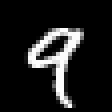

In [9]:
Gray.(dataset.features[:,:,5]')

## BME 574 Midterm Exam (take-home)

The dataset above is the famous MNIST dataset of handwritten digits (28x28 grayscale images).
The challenge for this midterm is to find the most informative pixels for each digit from this dataset
using techniques that you have learning previously.  Here is how to start:
1. Create a set of output (label) vectors $\{y_j\}$ of length 10 that represent the labels (0-9)
here are a few examples:
$$
\begin{align}
^{"}1^{"}=\begin{bmatrix} 1\\0\\0\\ \vdots \\0 \end{bmatrix}
\end{align}
$$
$$
\begin{align}
^{"}3^{"}=\begin{bmatrix} 0\\0\\1\\ \vdots \\0 \end{bmatrix}
\end{align}
$$

2. Now let $B$ be the set of output (label) vectors

$$
\begin{align}
B = \begin{bmatrix} y_{1} & y_{2} & y_{3} & \ldots & y_{n}\end{bmatrix}
\end{align}
$$

3. Let the matrix $A$ be the corresponding reshaped (vectorized) MNIST images (one in each row)

$$
\begin{align}
A = \begin{bmatrix} x_{1} & x_{2} & x_{3} & \ldots & x_{n}\end{bmatrix}
\end{align}
$$

4. $AX = B$ maps from the image space to the label space

Your task is to use solvers for $AX=B$ that promote sparsity to rank the pixels in the MNIST dataset that are most informative for correctly labeling the digits. You will have to come up with your own heuristics or empirical rules for this. Be sure to visualize the results from X. Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible. Redo the analysis with each digit individually to ﬁnd the most important pixels for each digit. Think about the interpretation of what you are doing with this $AX = B$ problem.
Hint: for testing, it may be a good idea to start with a smaller dataset (e.g. 1000 images)

### Data Processing
1. a function to process MNIST data with given sample size and random seed (process_mnist_data)
2. a function to extract images, labels and their indices of a specific target digit for a give processed dataset (get_digit_sepcific_sub_data)

In [10]:
function process_mnist_data(dataset::MNIST; sample_size::Int=1000, random_seed::Int=42)
    """
    process MNIST dataset in the following steps:
    1. Convert label to one-hot coded vectors in the length of 10, representing 0 to 9 for the 1st to 10nd element
    2. Vectorize 28×28 images and return all images as matrix A (n×784)
    3. Cbind all one-hot coded target labels as matrix B (n×10)
    4. Store and return the indeces of randomly selected samples
    """
    Random.seed!(random_seed)
    total_samples = length(dataset)
    # randomly select indices
    selected_indices = randperm(total_samples)[1:sample_size]
    # initialize matrices
    A = zeros(Float64, sample_size, 784)
    B = zeros(Float64, sample_size, 10)

    # process each selected sample
    for (i, idx) in enumerate(selected_indices)
        # get image and label
        image, label = dataset[idx]
        # process the image matrix: reshape to vector and normalize, the store at the ith row of matrix A
        A[i,:] = reshape(Float64.(image), :) ./255
        # creat one-hot label vector and store at the ith row of matrix B
        B[i, label+1] = 1.0 # for each row, the index of column for that labe should be label+1 since julia is 1-based indexing
    end
    
    return A, B, selected_indices
end

process_mnist_data (generic function with 1 method)

In [11]:
function get_digit_sepcific_sub_data(A::Matrix{Float64}, B::Matrix{Float64}, selected_indices::Vector{Int}, target_digit::Int)
    # find indices where that target digit appears in B
    digit_mask = B[:, target_digit+1] .== 1.0
    # extract corresponding rows and elements from A, B and selected_indices
    A_digit = A[digit_mask, :]
    B_digit = B[digit_mask, :]
    selected_indices_digit = selected_indices[digit_mask]

    return A_digit, B_digit, selected_indices_digit
end

get_digit_sepcific_sub_data (generic function with 1 method)

In [12]:
# take all training set
train_A, train_B, train_selected_indices = process_mnist_data(trainingset, sample_size=60000, random_seed=42);

In [13]:
# take all test set
test_A, test_B, test_selected_indices = process_mnist_data(testset, sample_size = 10000, random_seed=42);

### LASSO regression (L1 regularization)

In [14]:
function lasso(A, Y, λ1) # provided by Dr. Helmut Strey, modified to take one-hot coded Y as input
    (T, K) = size(A)
    (_, C) = size(Y)
    Q = A'A / T
    C_matrix = A'Y / T

    # Define variable matrix X (K x C)
    X = Variable(K, C)

    # Define the loss components
    L1 = quadform(X, Q; assume_psd=true)  # Quadratic term
    L2 = sum(dot(C_matrix[:, i], X[:, i]) for i in 1:C)  # Linear term
    L3 = norm(X, 1)  # L1 regularization term

    # Define and solve the optimization problem
    problem = minimize(L1 - 2*L2 + λ1*L3)
    solve!(problem, SCS.Optimizer; silent=true)

    return Convex.evaluate(X)  # Return optimized matrix X
end


lasso (generic function with 1 method)

A demo: \
obtaining the coefficient matrix with a subjectively selected $\lambda$ \
then plot one column of it via heatmap to check if the pattern of the corresponding digit could be shown

In [15]:
demo_x = lasso(train_A, train_B, 0.1);

In [16]:
reshaped_demo_x_digit = reshape(xx[:,3], 28, 28);
heatmap(reshaped_demo_x_digit, color=:viridis, title="Lasso Coefficients")
# rotation caused by both how heatmap works and the fact that MNIST dataset were in row-major order (when plotting, we need to transpose it)

LoadError: UndefVarError: `xx` not defined

In [17]:
# now a function to calculate the accuracy with test set
function compute_accuracy(A_test, Y_test, X)
    # Predicted scores (Ŷ = A_test * X)
    Ŷ = A_test * X

    # Predicted labels (argmax along rows)
    predicted_labels = argmax.(eachrow(Ŷ))

    # True labels (argmax along rows of Y_test)
    true_labels = argmax.(eachrow(Y_test))

    # Compute accuracy
    accuracy = sum(predicted_labels .== true_labels) / length(true_labels)

    return accuracy
end


compute_accuracy (generic function with 1 method)

In [18]:
compute_accuracy(test_A, test_B, demo_x)

0.7196

In [19]:
# then, a function to filter coefficients with large absolute values
function filter_important_pixels_quantile(X, quantile_threshold::Float64)
    """
    Filters the coefficient matrix X by retaining the top quantile of positive
    and negative coefficients separately.

    Parameters:
    - X: Coefficient matrix
    - quantile_threshold: Quantile threshold (e.g., 0.9 for top 10% in each part)

    Returns:
    - filtered_X: Coefficient matrix with unimportant coefficients set to 0
    """
    # Flatten X into a 1D array
    flattened_X = X[:]

    # Positive coefficients
    positive_coeffs = flattened_X[flattened_X .> 0]
    pos_cutoff = quantile(positive_coeffs, quantile_threshold)  # Quantile for positives

    # Negative coefficients
    negative_coeffs = flattened_X[flattened_X .< 0]
    neg_cutoff = quantile(negative_coeffs, 1 - quantile_threshold)  # Quantile for negatives

    # Create a mask for important coefficients
    important_mask = (X .>= pos_cutoff) .| (X .<= neg_cutoff)

    # Apply the mask: retain important coefficients, set others to 0
    filtered_X = X .* important_mask

    return filtered_X
end


filter_important_pixels_quantile (generic function with 1 method)

In [20]:
function filter_important_pixels_columnwise(X, quantile_threshold::Float64)
    """
    Apply the similar filter but for each column separately, to avoid range imbalance between digits.

    Parameters:
    - X: Coefficient matrix (K x C)
    - quantile_threshold: Quantile threshold (e.g., 0.9 for top 10% in each column)

    Returns:
    - filtered_X: Coefficient matrix with unimportant coefficients set to 0
    """
    # Initialize a filtered coefficient matrix with the same size as X
    filtered_X = zeros(size(X))

    # Iterate over each column
    for j in 1:size(X, 2)
        # Extract the j-th column
        column = X[:, j]

        # Positive coefficients
        positive_coeffs = column[column .> 0]
        pos_cutoff = quantile(positive_coeffs, quantile_threshold)  # Quantile for positives

        # Negative coefficients
        negative_coeffs = column[column .< 0]
        neg_cutoff = quantile(negative_coeffs, 1 - quantile_threshold)  # Quantile for negatives

        # Create a mask for important coefficients in the column
        important_mask = (column .>= pos_cutoff) .| (column .<= neg_cutoff)

        # Apply the mask to the column and store it in the filtered matrix
        filtered_X[:, j] = column .* important_mask
    end

    return filtered_X
end


filter_important_pixels_columnwise (generic function with 1 method)

In [21]:
filtered_demo_x = filter_important_pixels_quantile(demo_x, 0.7); # keep around the top 30% important pixels
compute_accuracy(test_A, test_B, filtered_demo_x)

0.6865

In [22]:
filtered_columnwise_demo_x = filter_important_pixels_columnwise(demo_x, 0.7); # keep around the top 30% important pixels
compute_accuracy(test_A, test_B, filtered_columnwise_demo_x)

0.7262

#### First, fitting X with all digits samples together
with the sampled training set and test set, run a for loop to select the $\lambda$ that achieves the best accuracy.

In [23]:
# a function to iterate λ and save the one with best accuracy
function find_best_lambda(A_train, Y_train, A_test, Y_test, lambdas)
    """
    Parameters:
    - A_train: Training feature matrix 
    - Y_train: One-hot encoded training labels 
    - A_test: Test feature matrix 
    - Y_test: One-hot encoded test labels 
    - lambdas: Array of lambda values to test

    Returns:
    - best_X: Coefficient matrix corresponding to the best lambda
    - best_lambda: The lambda value that achieved the highest accuracy
    - accuracies: Array of accuracies for each lambda
    """

    best_accuracy = 0.0
    best_lambda = 0.0
    best_X = nothing
    accuracies = Float64[]  # Store accuracies for each lambda

    for λ in lambdas
        # Train the model using the current lambda
        X = lasso(A_train, Y_train, λ)

        # Compute accuracy on the test set
        acc = compute_accuracy(A_test, Y_test, X)

        # Save accuracy for this lambda
        push!(accuracies, acc)

        # Update best lambda and model if accuracy improves
        if acc > best_accuracy
            best_accuracy = acc
            best_lambda = λ
            best_X = X
        end
    end

    return best_X, best_lambda, accuracies
end


find_best_lambda (generic function with 1 method)

In [24]:
lambdas = 0.01:0.02:0.6
alldigits_best_X, alldigits_best_lambda, alldigits_accuracies = find_best_lambda(train_A, train_B, test_A, test_B, lambdas);

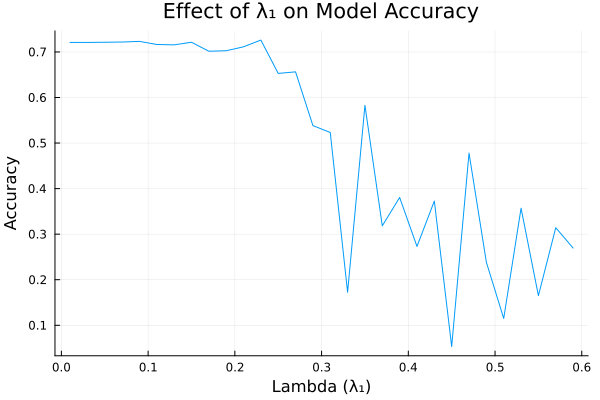

In [25]:
# Plot the accuracy trend
plot(lambdas, alldigits_accuracies, xlabel="Lambda (λ₁)", ylabel="Accuracy", title="Effect of λ₁ on Model Accuracy", legend=false)

In [26]:
println("Best Lambda: $alldigits_best_lambda with Accuracy: $(maximum(alldigits_accuracies))")

Best Lambda: 0.23 with Accuracy: 0.7261


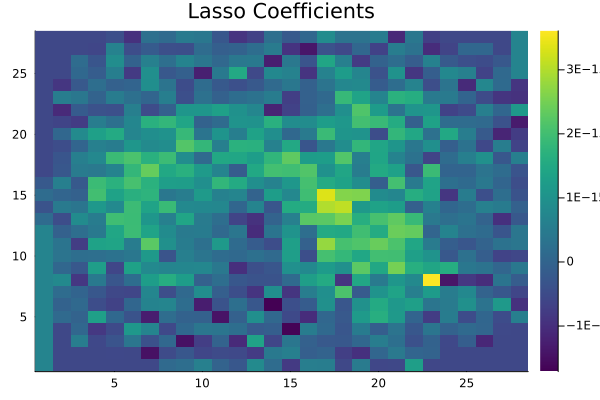

In [27]:
reshaped__xdigit = reshape(alldigits_best_X[:,3], 28, 28);
heatmap(reshaped__xdigit, color=:viridis, title="Lasso Coefficients")


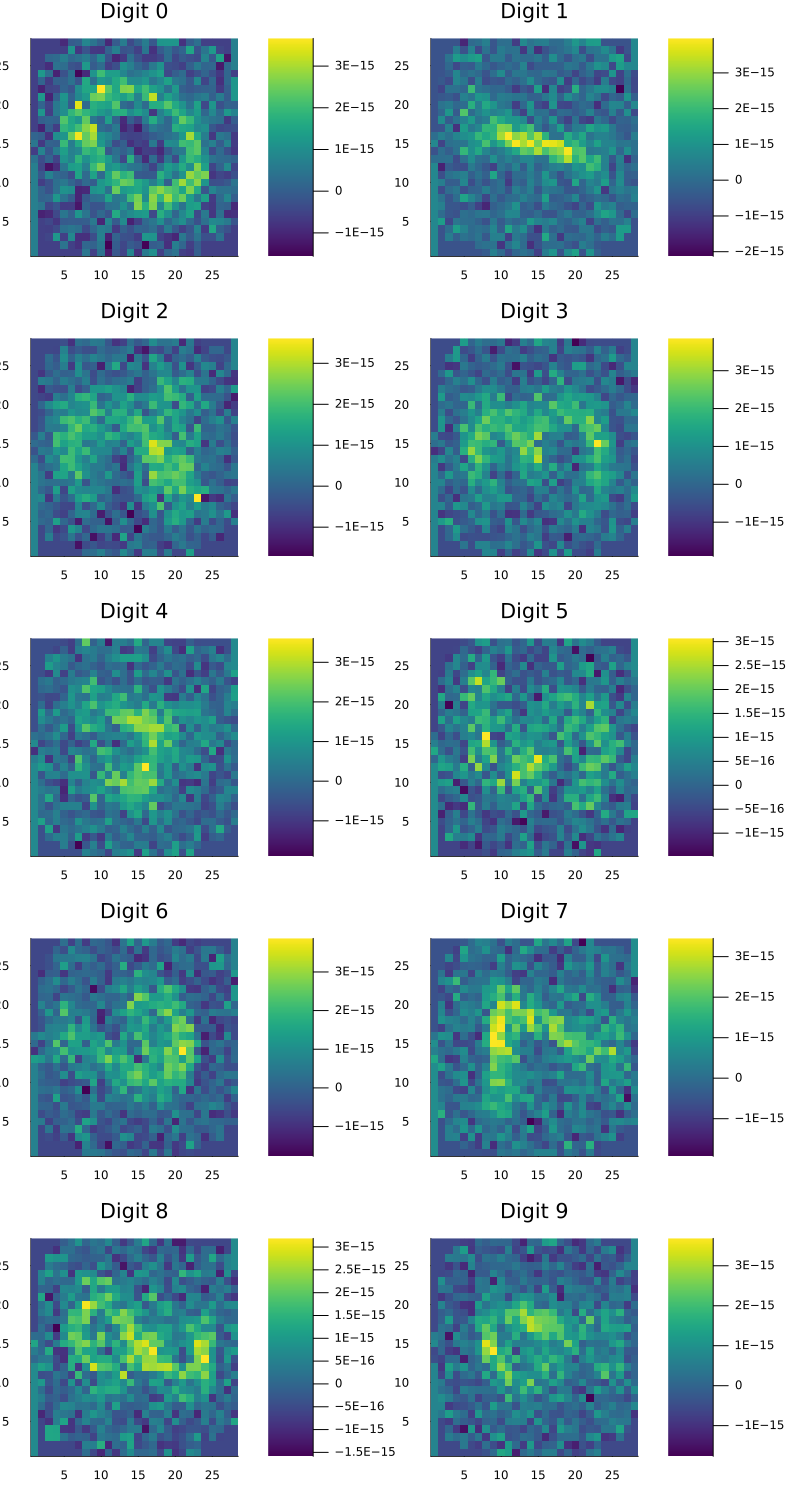

In [28]:
plots = []

for i in 1:10
    reshaped_xdigit = reshape(alldigits_best_X[:, i], 28, 28)
    p = heatmap(reshaped_xdigit, color=:viridis, title="Digit $(i-1)", xlabel="", ylabel="")
    push!(plots, p)
end

# Create a grid layout (5 rows x 2 columns)
plot(plots..., layout=(5, 2), size=(800, 1500))


In [29]:
# with the best λ and the corresponding fitting result, iterate quantiles and take a look at the changes of accuracy along quantiles
function iterate_quantiles_and_plot(A_train, Y_train, A_test, Y_test, best_X, quantiles; columnwise)
    """
    Iterates over different quantile thresholds to mask the coefficient matrix, filters
    the important pixels, and evaluates accuracy for each quantile.

    Parameters:
    - A_train: Training feature matrix
    - Y_train: One-hot encoded training labels
    - A_test: Test feature matrix
    - Y_test: One-hot encoded test labels
    - best_X: Coefficient matrix obtained with the best lambda
    - quantiles: Array of quantile thresholds to test
    - columnwise: boolea, define which quantile method to use

    Returns:
    - results: A DataFrame with columns:
      - quantile_threshold: The quantile threshold
      - num_pixels: The number of remaining pixels after filtering
      - acc: The accuracy achieved with the filtered coefficients
    """
    results = DataFrame(quantile=Float64[], num_pixels=Int64[], accuracy=Float64[])

    for quantile_threshold in quantiles
        # Filter the coefficient matrix using the quantile threshold
        if columnwise
            filtered_X = filter_important_pixels_columnwise(best_X, quantile_threshold)
        else
            filtered_X = filter_important_pixels_quantile(best_X, quantile_threshold)
        end

        # Count the number of non-zero pixels (important pixels)
        num_pixels = count(!iszero, filtered_X[:])

        # Evaluate accuracy on the test set
        acc = compute_accuracy(A_test, Y_test, filtered_X)

        # Save the results
        push!(results, (quantile_threshold, num_pixels, acc))
    end

    return results
end


iterate_quantiles_and_plot (generic function with 1 method)

In [41]:
quantiles = 0.5:0.02:0.99;
results = iterate_quantiles_and_plot(train_A, train_B, test_A, test_B, alldigits_best_X, quantiles; columnwise=false);
columnwise_results = iterate_quantiles_and_plot(train_A, train_B, test_A, test_B, alldigits_best_X, quantiles; columnwise=true);

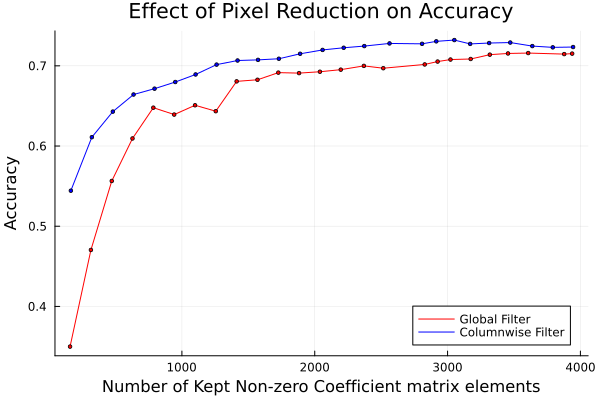

In [42]:
# Plot the first set of results
plot(results.num_pixels, results.accuracy, xlabel="Number of Kept Non-zero Coefficient matrix elements", ylabel="Accuracy",
     title="Effect of Pixel Reduction on Accuracy", label="Global Filter", color=:red)

# Add dots to the first plot
scatter!(results.num_pixels, results.accuracy, color=:red, label="", markersize=2)

# Add the second set of results to the same plot
plot!(columnwise_results.num_pixels, columnwise_results.accuracy, label="Columnwise Filter", color=:blue)

# Add dots to the second plot
scatter!(columnwise_results.num_pixels, columnwise_results.accuracy, color=:blue, label="", markersize=2)


Columnwise filter works better, and in this way, keeping about 14% of pixels could still remain a good model performance.

In [43]:
columnwise_results # take a look at the elbow's quantail to support the statement above

25×3 DataFrame
 Row │ quantile  num_pixels  accuracy 
     │ Float64   Int64       Float64  
─────┼────────────────────────────────
   1 │     0.5         3945    0.7234
   2 │     0.52        3792    0.723
   3 │     0.54        3638    0.7246
   4 │     0.56        3472    0.729
   5 │     0.58        3313    0.7284
   6 │     0.6         3170    0.7273
   7 │     0.62        3051    0.7321
   8 │     0.64        2915    0.7305
   9 │     0.66        2808    0.7274
  10 │     0.68        2563    0.7279
  11 │     0.7         2373    0.7246
  ⋮  │    ⋮          ⋮          ⋮
  16 │     0.8         1573    0.7074
  17 │     0.82        1419    0.7066
  18 │     0.84        1261    0.7015
  19 │     0.86        1103    0.6892
  20 │     0.88         950    0.6798
  21 │     0.9          794    0.6715
  22 │     0.92         636    0.6642
  23 │     0.94         480    0.6429
  24 │     0.96         322    0.611
  25 │     0.98         164    0.5443
                        4 rows omitted

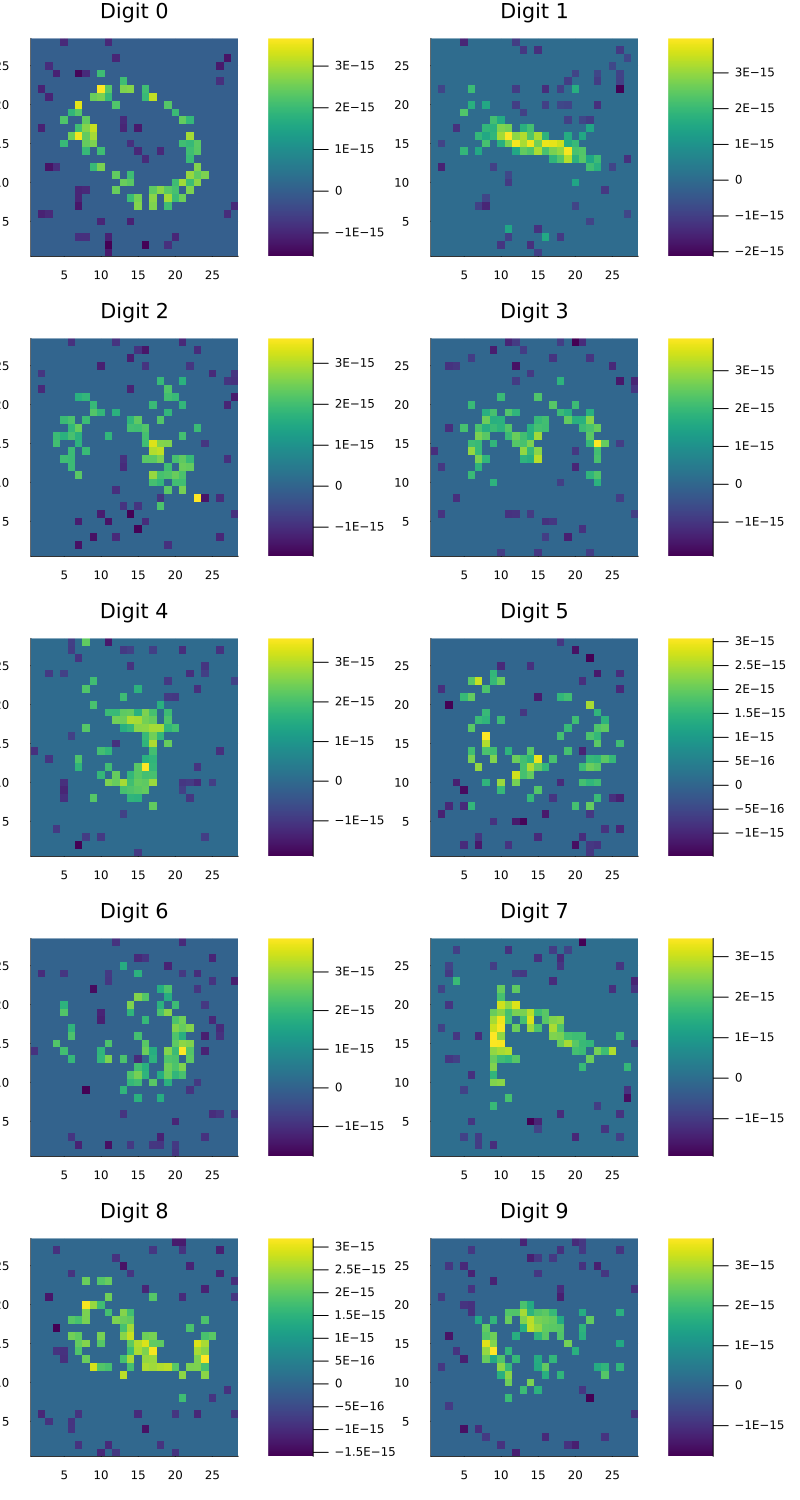

In [44]:
filtered_alldigits_X = filter_important_pixels_columnwise(alldigits_best_X, 0.86)

plots = []
for i in 1:10
    reshaped_xdigit = reshape(filtered_alldigits_X[:, i], 28, 28)
    p = heatmap(reshaped_xdigit, color=:viridis, title="Digit $(i-1)", xlabel="", ylabel="")
    push!(plots, p)
end

# Create a grid layout (5 rows x 2 columns)
plot(plots..., layout=(5, 2), size=(800, 1500))


#### Redo the analysis above with each digit individually
Digit label (B, or Y) should be recoded from 10 channle one-hot coded to 2 channel one-hot coded representing "yes" or "no" for that digit.

In [34]:
# function to recode labels
function convert_to_binary_labels(Y, digit)
    """
    Converts one-hot encoded labels into binary labels with 2 channels for a specific digit.

    Parameters:
    - Y: One-hot encoded labels with 10 channels
    - digit: Target digit for binary classification

    Returns:
    - binary_Y: Binary labels, where the first channel is "yes" and the second is "no, other digits"
    """
    binary_Y = zeros(size(Y, 1), 2)  # Initialize a binary label matrix (T x 2)
    
    for (i, label) in enumerate(eachrow(Y))
        if label[digit + 1] == 1  # Yes, is the digit
            binary_Y[i, 1] = 1.0
        else  # No, it is other digits
            binary_Y[i, 2] = 1.0
        end
    end

    return binary_Y
end


# function to find best λ for each digit, and then iterate through quantiles filtering with columnwise manner
function analyze_digit(A_train, Y_train, A_test, Y_test, digit, lambdas, quantiles)
    """
    Analyzes the most important pixels for a specific digit.

    Parameters:
    - A_train, Y_train: Training feature matrix and one-hot encoded labels
    - A_test, Y_test: Test feature matrix and one-hot encoded labels
    - digit: Target digit for analysis
    - lambdas: Array of lambda values to test
    - quantiles: Array of quantile thresholds to test

    Returns:
    - results: DataFrame with quantile thresholds, number of important pixels, and accuracy
    - best_lambda: Best lambda for the digit
    - filtered_X: Filtered coefficient matrix for the digit
    """

    # Convert labels to binary for the target digit
    binary_Y_train = convert_to_binary_labels(Y_train, digit)
    binary_Y_test = convert_to_binary_labels(Y_test, digit)

    # Find the best lambda for the digit
    best_X, best_lambda, _ = find_best_lambda(A_train, binary_Y_train, A_test, binary_Y_test, lambdas)

    # Iterate over quantiles for filtering
    results = iterate_quantiles_and_plot(A_train, binary_Y_train, A_test, binary_Y_test, best_X, quantiles, columnwise=true)

    return results, best_lambda, best_X
end

# based on the function above, here is the function to run all digits one by one
function analyze_all_digits(A_train, Y_train, A_test, Y_test, lambdas, quantiles)
    """
    Performs the analysis for all digits (0–9).

    Parameters:
    - A_train, Y_train: Training feature matrix and one-hot encoded labels
    - A_test, Y_test: Test feature matrix and one-hot encoded labels
    - lambdas: Array of lambda values to test
    - quantiles: Array of quantile thresholds to test

    Returns:
    - all_results: Dictionary mapping each digit to its analysis results
    """
    all_results = Dict()

    for digit in 0:9
        println("Analyzing digit $digit...")
        results, best_lambda, best_X = analyze_digit(A_train, Y_train, A_test, Y_test, digit, lambdas, quantiles)
        all_results[digit] = (results, best_lambda, best_X)
    end

    return all_results
end


analyze_all_digits (generic function with 1 method)

In [45]:
# Define lambda and quantile ranges
lambdas = 0.01:0.02:0.6;
quantiles = 0.5:0.02:0.99;

# Analyze all digits
all_results = analyze_all_digits(train_A, train_B, test_A, test_B, lambdas, quantiles);

Analyzing digit 0...
Analyzing digit 1...
Analyzing digit 2...
Analyzing digit 3...
Analyzing digit 4...
Analyzing digit 5...
Analyzing digit 6...
Analyzing digit 7...
Analyzing digit 8...
Analyzing digit 9...


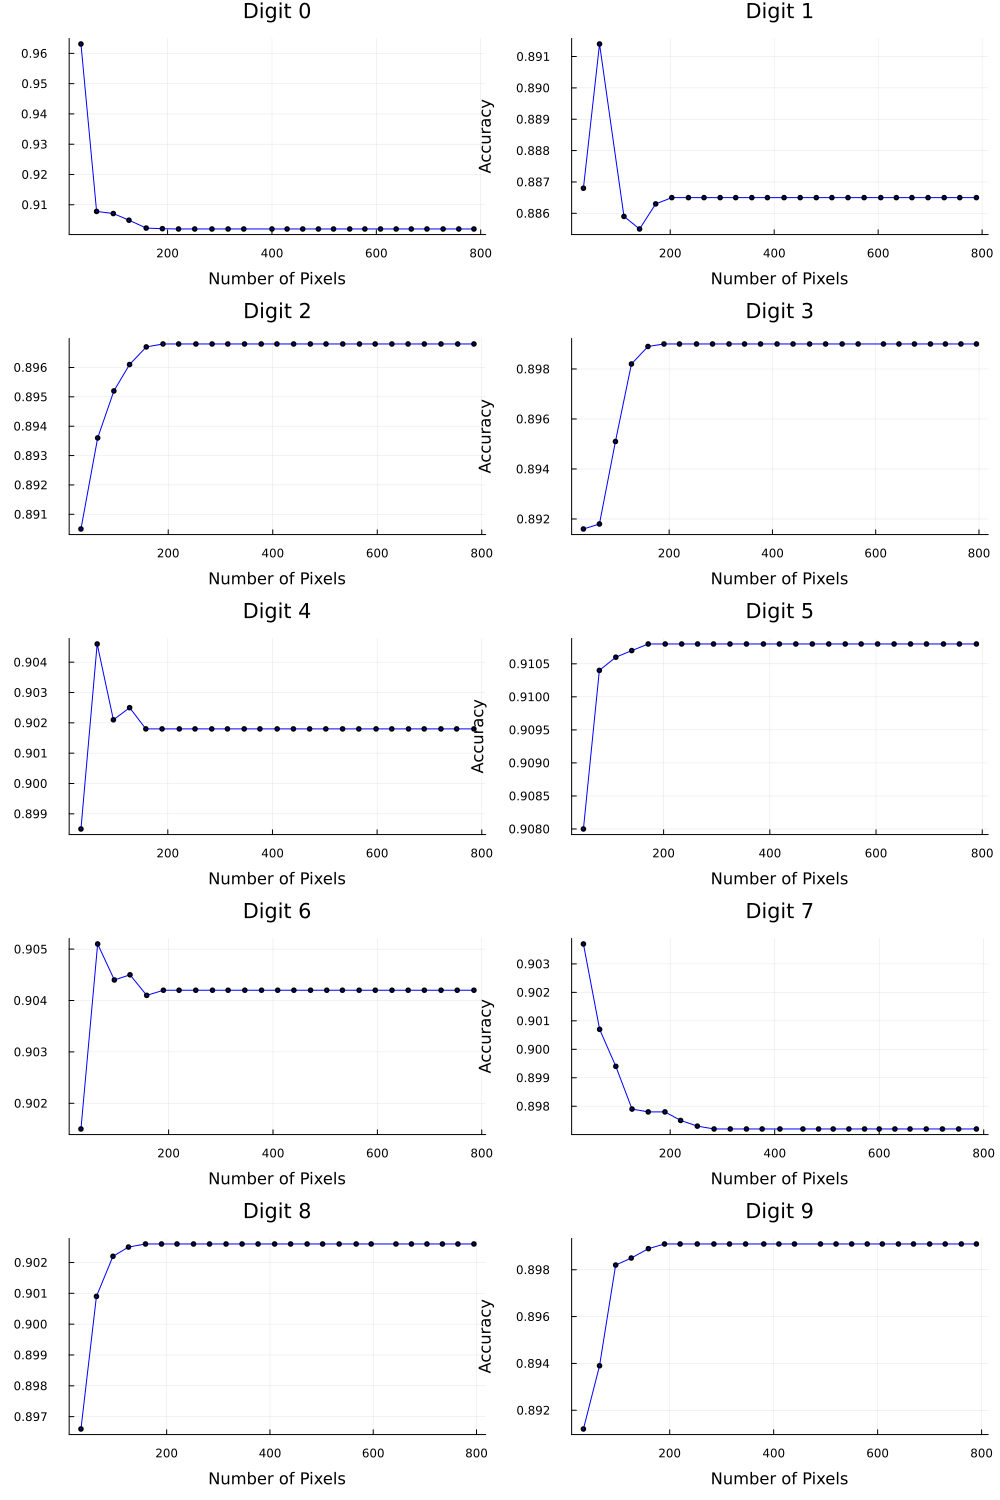

In [46]:
# a for loop to obtain trend of kept pixels and accuracy for all digits
plots = []

for digit in 0:9
    # Access results for the current digit
    digit_results, digit_best_lambda, digit_best_X = all_results[digit]

    # Create a plot for the current digit with consistent y-axis limits
    p = plot(
        digit_results.num_pixels, digit_results.accuracy,
        xlabel="Number of Pixels", ylabel="Accuracy",
        title="Digit $digit",
        legend=false, color=:blue, label="Trend"
    )

    # Add scatter points to the plot
    scatter!(
        digit_results.num_pixels, digit_results.accuracy,
        color=:blue, label="", markersize=2
    )

    # Add the plot to the list
    push!(plots, p)
end

# Combine all plots in a 5x2 grid layout
plot(plots..., layout=(5, 2), size=(1000, 1500))


In [47]:
function plot_digit_coefficients_with_quantile(best_X, quantile_threshold)
    # Extract the coefficients for "yes" (first column)
    digit_coefficients = best_X[:, 1]

    # Apply quantile-based filtering
    filtered_coefficients = filter_important_pixels_quantile(digit_coefficients, quantile_threshold)

    # Reshape the filtered coefficients to a 28x28 matrix
    reshaped_coefficients = reshape(filtered_coefficients, 28, 28)

    # Plot the heatmap
    heatmap(
        reshaped_coefficients, color=:viridis,
        title="Digit Coefficients with Quantile $quantile_threshold",
        xlabel="Pixels", ylabel="Pixels",
        clims=(-maximum(abs.(reshaped_coefficients)), maximum(abs.(reshaped_coefficients)))
    )
end


plot_digit_coefficients_with_quantile (generic function with 1 method)

Digit: 0, Quantile: 0.98, Accuracy: 0.9631
Digit: 1, Quantile: 0.88, Accuracy: 0.8865
Digit: 2, Quantile: 0.88, Accuracy: 0.8968
Digit: 3, Quantile: 0.9, Accuracy: 0.8989
Digit: 4, Quantile: 0.9, Accuracy: 0.9018
Digit: 5, Quantile: 0.94, Accuracy: 0.9106
Digit: 6, Quantile: 0.9, Accuracy: 0.9041
Digit: 7, Quantile: 0.9, Accuracy: 0.8978
Digit: 8, Quantile: 0.92, Accuracy: 0.9025
Digit: 9, Quantile: 0.9, Accuracy: 0.8989


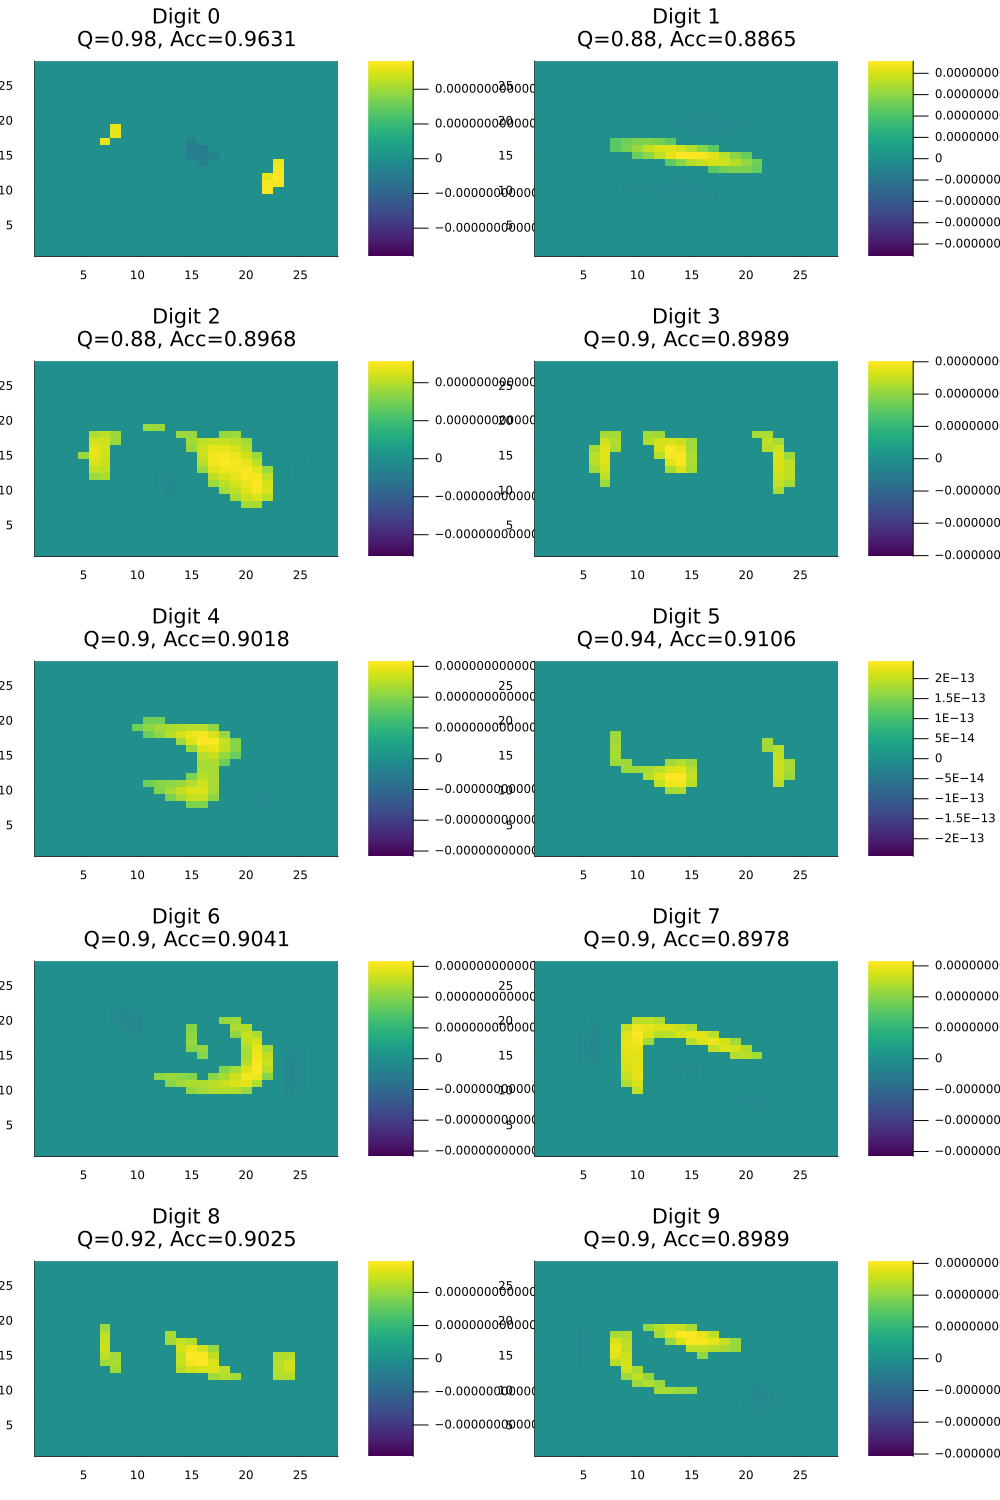

In [48]:
quantiles = [0.98, 0.88, 0.88, 0.90, 0.90, 0.94, 0.90, 0.90, 0.92, 0.90] # higer quantiles mean less kept pixels

plots = []

using Plots

# Initialize a list to store individual plots
plots = []

# Iterate over all digits
for digit in 0:9
    # Extract the results for the current digit
    digit_results, _, best_X = all_results[digit]

    # Get the manually selected quantile for this digit
    quantile_threshold = quantiles[digit + 1]

    # Find the row in the DataFrame corresponding to the selected quantile
    quantile_row = findfirst(x -> x == quantile_threshold, digit_results.quantile)
    if quantile_row !== nothing
        accuracy = digit_results.accuracy[quantile_row]  # Get the accuracy for this quantile
    else
        accuracy = "N/A"  # Handle missing case if the quantile isn't in the DataFrame
    end

    # Print the digit, quantile, and corresponding accuracy
    println("Digit: $digit, Quantile: $quantile_threshold, Accuracy: $accuracy")

    # Extract the coefficients for "yes" (first column)
    digit_coefficients = best_X[:, 1]

    # Apply quantile-based filtering
    filtered_coefficients = filter_important_pixels_quantile(digit_coefficients, quantile_threshold)

    # Reshape the filtered coefficients to a 28x28 matrix
    reshaped_coefficients = reshape(filtered_coefficients, 28, 28)

    # Create the heatmap for the current digit
    p = heatmap(
        reshaped_coefficients, color=:viridis,
        title="Digit $digit\nQ=$quantile_threshold, Acc=$accuracy",
        xlabel="", ylabel="",
        clims=(-maximum(abs.(reshaped_coefficients)), maximum(abs.(reshaped_coefficients)))
    )

    # Add the plot to the list
    push!(plots, p)
end

# Combine all plots into a 5x2 grid
plot(plots..., layout=(5, 2), size=(1000, 1500))
